## Pengenalan aksara jawa dengan convolutional neural network

Refrensi : 

Pengenalan aksara lontar dengan Convolutional Neural Network berbasis android, Ridwan Nur, Septi Andryana, Winarsih (2018)

Aksara Jawa Text Detection in Scene Images using Convolutional Neural Network, 
Muhammad Labiyb Afakh, Anhar Risnumawan, Martianda Erste Anggraeni,
Mohamad Nasyir Tamara, and Endah Suryawati Ningrum (2017)



Dalam program ini menggunakan tensorflow sebagai pihak ketiga untuk membantu proses pelatihan data serta pengujian data dengan masukan gambar melalui unggah gambar

##Google Drive

Input file dataset yang telah di unggah ke dalam drive kemudian memanggil dataset tersebut dengan fungsi drive.mount untuk mengaitkan drive dengan colaboratoy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Library

Import pihak ketiga yang dibutuhkan seperti tensorflow untuk membuat dan melatih model sklearn untuk memproses gambar

In [ ]:
# prep
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import glob
import time
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#cnn
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as conv2d
from tensorflow.keras.layers import MaxPooling2D as maxpool2d
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D as globalmaxpooling2d
from tensorflow.keras.layers import Activation as activation
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD


%matplotlib inline

## Import dataset

Java script dataset obtained from kaggle
https://www.kaggle.com/phiard/aksara-jawa

There are two datasets needed to import this dataset, namely training data and validation data taken based on the directory path, then determine the image size using the target size, then rescale the image to the image size / 255

The images used in this test are 150x150 in size, 3 dimensions and RGB images

In [ ]:
# masukan gambar dengan upload gambar uji ukuran target_size 150x150 dengan input target_size = 150x150 dimensi 3 rgb
# masukan gambar dengan tulisan tangan uji ukuran target_size 28x28 dengan input target_size = 28x28 dimensi 1 grayscale

In [ ]:
#membuat data latih
train_data = ImageDataGenerator(
    rescale = 1/255,
)

data_uji = train_data.flow_from_directory(
        directory = "/content/drive/MyDrive/CNN aksara jawa/train",
        target_size = (150,150),
        batch_size = 4,
        class_mode='categorical'
)


Found 2264 images belonging to 20 classes.


In [ ]:
#membuat data validasi
validation_data = ImageDataGenerator(
    rescale = 1/255,
)

data_validasi = validation_data.flow_from_directory(
        directory = "/content/drive/MyDrive/CNN aksara jawa/val",
        target_size = (150,150),
        class_mode='categorical',
        batch_size = 4
)

Found 485 images belonging to 20 classes.


## Show data image

Displaying the dataset that will be used later with matplotlin we can display an image with a graph of the size of the image the image is taken based on a predetermined path

In [ ]:
#menampilkan data

def datagambar(gambar):
    plt.figure()
    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('white')
    
    for i in range(len(gambar)):
        plt.subplot(5,5,i+1)
        img = mpimg.imread(gambar[i])
        plt.imshow(img)
        plt.tight_layout()
        plt.title(gambar[i].split("/")[1])
        img.shape
    plt.show()
    
    
def list_files(dir):
    arr = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            if name.endswith(".jpg"):
              arr.append(os.path.join(root, name))
              break
    return arr

<Figure size 432x288 with 0 Axes>

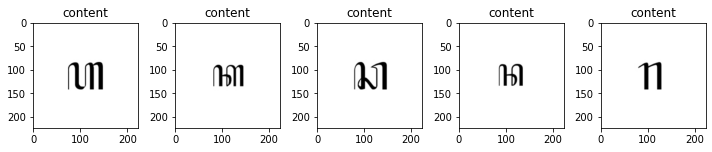

In [ ]:
# data latih
dir = list_files("/content/drive/MyDrive/CNN aksara jawa/train")
datagambar(dir)

In [ ]:
# data validasi
dirval = list_files("/content/drive/MyDrive/CNN aksara jawa/val")
datagambar(dirval)

<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

## Show data spread

View the distribution of datasets by number and folder name

In [ ]:
#fungsi persebaran data
def hitung(data):
    arr = []
    for root,dirs, files in os.walk(data):
        jumlah = 0
        for name in files:
            if name.endswith(".jpg") or name.endswith(".png"):
              jumlah = jumlah + 1
        if jumlah > 0:
          arr.append(jumlah)
    return arr

def nama(data):
    arr = []
    for root, dirs, files in os.walk(data):

        arr.append(dirs)
        break
    return arr

In [ ]:
#pesebaran data latih
jumlah_gambar = hitung("/content/drive/MyDrive/CNN aksara jawa/train")
print(len(jumlah_gambar))

nama_folder = nama("/content/drive/MyDrive/CNN aksara jawa/train")
print(nama_folder)

20
[['la', 'ga', 'da', 'dha', 'ja', 'ma', 'nga', 'pa', 'nya', 'sa', 'ba', 'ta', 'tha', 'wa', 'ya', 'ha', 'ka', 'ca', 'na', 'ra']]


In [ ]:
#pesebaran data validasi
jumlah_gambaruji = hitung("/content/drive/MyDrive/CNN aksara jawa/val")
print(len(jumlah_gambaruji))
nama_folderuji = nama("/content/drive/MyDrive/CNN aksara jawa/val")
print(nama_folderuji)

20
[['ma', 'la', 'nga', 'ja', 'da', 'ga', 'dha', 'ba', 'nya', 'pa', 'ya', 'tha', 'wa', 'ta', 'sa', 'ca', 'ha', 'ka', 'ra', 'na']]


## Build Model

Creating a model and cnn architecture, the model will be used for training and then recognize the pattern image that is entered. This model is of sequential type, which means that the Sequential Model is suitable for ordinary layer stacks where each layer has exactly one input tensor and one output tensor,

After the model is made then create a convulitonal layer as a 6x6 filter then input the 150x150x3 shape.

after entering the convolutional layer then enter the maxpooling layer size 3x3 to take a sample of each input image if the data has entered the maxpool column then flatten to delete all data except one value,

after flatten enter into dropout function i.e. randomly assign input unit to 0 with rate frequency at each step during training time with probability 0.1.
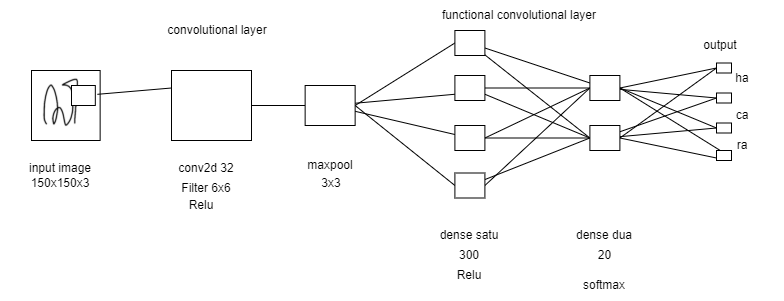


In [ ]:
#Pengaturan Ukuran
np.random.seed(23)
pool_size = (3, 3) #ukuran tabel pooling
prob_drop_conv = 0.1   #probilitas untuk layer convolutional
prob_drop_hidden = 0.3  #probilitas untuk layer fully connected 


model = Sequential()

#layer convolutional satu c1
model.add(conv2d(8, (8, 8), padding='same', activation='relu', input_shape=(150, 150 ,3))) #dimensi rgb

#layer convolutional satu c1
model.add(conv2d(32, (6, 6),activation='relu')) #dimensi rgb

#layer maxpoool
model.add(maxpool2d(pool_size=pool_size, strides=(2,2), padding='same'))
model.add(Flatten())
model.add(Dropout(prob_drop_conv))

#layer fully connected satu
model.add(Dense(300, activation='relu'))
model.add(Dropout(prob_drop_hidden))

#layer fully connected dua
model.add(Dense(20, activation='softmax'))

#compile model dengan optimizer adam
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#property dari model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 8)       1544      
                                                                 
 conv2d_1 (Conv2D)           (None, 145, 145, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 170528)            0         
                                                                 
 dropout (Dropout)           (None, 170528)            0         
                                                                 
 dense (Dense)               (None, 300)               51158700  
                                                        

## Train model

At this stage train the data with data validation, iterations or stages at this stage as many as 20 each stage 128 then validation stage 10, the model will use the fit() function to train the data

In [ ]:
#fit atau latih data dengan data latih dan validasi
model.fit(
    data_uji,
    epochs=20,
    steps_per_epoch = 128,
    shuffle=True,
    validation_data= data_validasi, 
    validation_steps = 10,
    verbose=1
)

Epoch 1/20
128/128 [==============================] - 276s 2s/step - loss: 4.1385 - accuracy: 0.2402 - val_loss: 1.9956 - val_accuracy: 0.3500
Epoch 2/20
128/128 [==============================] - 220s 2s/step - loss: 1.4264 - accuracy: 0.6016 - val_loss: 2.8129 - val_accuracy: 0.3000
Epoch 3/20
128/128 [==============================] - 175s 1s/step - loss: 0.9497 - accuracy: 0.7090 - val_loss: 2.1573 - val_accuracy: 0.4500
Epoch 4/20
128/128 [==============================] - 149s 1s/step - loss: 0.5857 - accuracy: 0.8164 - val_loss: 2.6156 - val_accuracy: 0.4250
Epoch 5/20
128/128 [==============================] - 144s 1s/step - loss: 0.3184 - accuracy: 0.8906 - val_loss: 2.2392 - val_accuracy: 0.5000
Epoch 6/20
128/128 [==============================] - 138s 1s/step - loss: 0.2689 - accuracy: 0.9121 - val_loss: 2.2272 - val_accuracy: 0.3750
Epoch 7/20
128/128 [==============================] - 129s 999ms/step - loss: 0.2674 - accuracy: 0.9277 - val_loss: 2.9316 - val_accuracy: 0.3

## Evaluate Model 1

at this stage is to evaluate the model that has been made with the training data so that it can find out the difference between the model when it is trained with the first training data

In [ ]:
#evaluasi data model dengan data latih sebelum dengan data validasi
test_val,test_acc = model.evaluate(data_uji)

print(test_acc)

566/566 [==============================] - 69s 122ms/step - loss: 0.0157 - accuracy: 0.9969
0.9969081282615662


## Evaluate Model 2

at this stage, namely evaluating the model with validation data as in the evaluation stage of model one

In [ ]:
#evaluasi data model dengan data validasi sendiri
test_val,test_acc = model.evaluate(data_validasi)

print(test_acc)

122/122 [==============================] - 45s 371ms/step - loss: 2.8947 - accuracy: 0.5175
0.5175257921218872


In [ ]:
#prediksi model
pred = model.predict(data_validasi)
prediksi = np.argmax(pred, axis=1)
print(prediksi)

[14 16  1 14 19  1 10  5  5  0 10 10  5 17 17  1  4  9 11  5 14  2 16 16
 16 14 18 12 12 18 15 16  6 18  8 10  4 12  1  2  5 14  9 12 18  5  8 10
 10  8  5 18  2  8 18 17 10 15  1 16 12  9 18 12  6 15  4  5  0 13 10 13
 13  3 12 14 13  1  1 15 10 10 16  4  9  5 12  1  2 10 17  5  5  4 17  5
 16 18  5 19 10 12 10  7 14 16  7  4  2 18 17  7 14  3 12  5  1  4 16  5
  1  2  5 10  9  5 12  5 18 10  7  9 11  3 18  2 10 19  1  6 10 14  7 10
  2  5 12 12  1 16  4 12  7  5  6  4  5  9 14  6 12 15  8 12  4 11 12  8
 12  7 12 14  3  8 19 11 12 16 15 13  4  2  8 14 16 15 15 13  3 16  8  1
 12 15  1  7 14  4 10 10 18 16  5  5 12  5  1 10 10 12 10  4  5  0 11  1
 17 12  4  9  4 12 16  5 13  5 10  9 12 11 15 12 10  5  8  1  9 10 18  8
  5 11 19  6 15 14  9  5  8 10 12 11  7  5  9 14  0 14 16 19 12  9 16 10
 12 18 18  1 11  5 13 10 13  6 10  5  6 10  1  1 16  5 10  8 12 19 14  7
 10  5 11 14 10 19 10 14  5 15  5  5 15  5 12 11 18 11  8 17 10 11  4 15
 14 11 10  5 12  6 10 16 12 12 13 12  6  3  1 18 17

## Evaluate Model 3

At this stage, namely evaluating the model by uploading an image then the model will predict the image. Taking the libraries needed to take images and preprocessing images

In [ ]:
#test data dengan upload
from google.colab import files
from keras.preprocessing import image

Saving Webp.net-resizeimage (2).png to Webp.net-resizeimage (2) (1).png
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
14
aksara terdeteksi : ra 


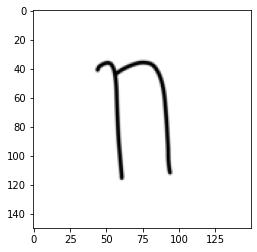

In [ ]:
up = files.upload()

for file in up.keys():

    #preprocessing gambar
    path = file
    img = image.load_img(path,target_size=(150,150)) 
    imgplot = plt.imshow(img)

    #process gambar
    x = image.img_to_array(img)
    x = np.expand_dims(x,axis=0)

    data = np.vstack([x])
    kelas = model.predict(data, batch_size=10)

    print(kelas)

    final = np.argmax(kelas)

    print(final)

    #klasifikasisan berdasrkan posisi angka pada array
    if final==0:
          print("aksara terdeteksi : ba ")

    if final==1:
          print("aksara terdeteksi : ca ")

    if final==2:
          print("aksara terdeteksi : da ")

    if final==3:
          print("aksara terdeteksi : dha ")

    if final==4:
          print("aksara terdeteksi : ga ")
        
    if final==5:
          print("aksara terdeteksi : ha ")

    if final==6:
          print("aksara terdeteksi : ja ")

    if final==7:
          print("aksara terdeteksi : ka ")

    if final==8:
          print("aksara terdeteksi : la ")

    if final==9:
          print("aksara terdeteksi : ma ")

    if final==10:
          print("aksara terdeteksi : na ")

    if final==11:
          print("aksara terdeteksi : nga ")
      
    if final==12:
          print("aksara terdeteksi : nya ")

    if final==13:
          print("aksara terdeteksi : pa ")

    if final==14:
          print("aksara terdeteksi : ra ")

    if final==15:
          print("aksara terdeteksi : sa ")

    if final==16:
          print("aksara terdeteksi : ta ")

    if final==17:
          print("aksara terdeteksi : tha ")

    if final==18:
          print("aksara terdeteksi : wa ")

    if final==19:
          print("aksara terdeteksi : ya ")

## Konversi model

At this stage, which is converting the model that has been made into a lite version model so that it can be used on smartphone devices, in converting this using the tensorflow lite library to help convert to using the tensorflow lite model the model must be a 28x28 input dimension 1


In [ ]:
#konverter model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_float_model = converter.convert()

float_model_size = len(tf_lite_float_model) / 1024
print("ukuran = %dKBs" % float_model_size)

After the conversion, the first stage then converts the model into a veris quantize for smaller ones

In [ ]:
#konvert ke model quantineze
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = converter.convert()

tflite_model_quant_size = len(tflite_model_quant) / 1024
print("ukuran = %dKBs" % tflite_model_quant_size)

The last step is to download the model that has been converted to a tflite model

In [ ]:
from google.colab import files
#import ke model

f = open('aksaramodel281.tflite','wb')
f.write(tflite_model_quant)
f.close()
files.download('aksaramodel281.tflite')